# Code for experimenting with impelementing periodicity

In [4]:
import scipy.io
import numpy as np

initialdata = scipy.io.loadmat('./data/test_case.mat')

Z_test_1 = initialdata['Z_test'][:,:,0]
Z_test_2 = initialdata['Z_test'][:,:,1]
Z_test_3 = initialdata['Z_test'][:,:,2]
amp = initialdata['amp'][0][0]
bx = initialdata['bx'][0]
f = initialdata['f'][0][0]
g = initialdata['g'][0][0]
M = initialdata['M']
Nsq = initialdata['Nsq'][0][0]
s = initialdata['s'][0][0]
th0 = initialdata['th0'][0][0]
w_test_1 = initialdata['w_test'][:,0]
w_test_2 = initialdata['w_test'][:,1]
w_test_3 = initialdata['w_test'][:,2]

import auxfunctions as aux

# Load the data from the MessagePack file
Z, C, W, M = aux.load_data('./data/SG_data.msgpack')

# Compute the Velocities, Temperature, and Kinetic Energy
MVel, T = aux.Properties(Z, C, W, M, bx, th0, f, g)

maxvel = np.max(MVel)
minvel = np.min(MVel)

print(bx)

[-1000000.                0.          1000000.            10224.85302701]


In [5]:
from pysdot.domain_types import ConvexPolyhedraAssembly
from pysdot import PowerDiagram
import pyvista as pv

positions = Z_test_1
domain = ConvexPolyhedraAssembly()
domain.add_box([bx[0], bx[1]], [bx[2], bx[3]])
w0 = w_test_1
pd = PowerDiagram( positions = positions, domain = domain, weights = w0 )

filename = 'pb.vtk'
pd.display_vtk( filename )

/home/s2250115/.local/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


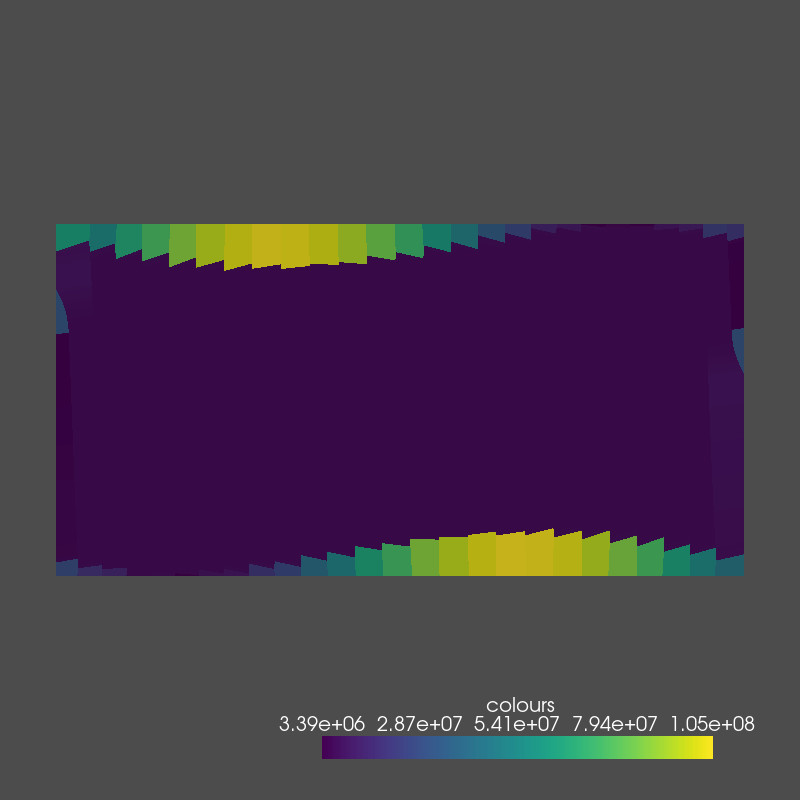

In [13]:
# Mass of cells
colours=pd.integrals()

# Read the data
grid=pv.read(filename)

# create cell data that gives the cell volumes, this allows us to colour by cell volumes
cell_colours = colours[grid.cell_data['num'].astype(int)]
grid.cell_data['colours']=cell_colours

# plot the data with an automatically created plotter, for a static picture use backend='static'
plotter = pv.Plotter(window_size=[800,800], notebook = True, off_screen=False)
plotter.add_mesh(grid) #, clim=[minvel, maxvel])

plotter.set_scale(xscale=0.1, yscale=10)

# Set the camera for 2D view
plotter.camera_position = 'xy'

# Render the frame
plotter.show()

In [ ]:
import matplotlib.pyplot as plt

#Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot()
ax.scatter(Z_test_3[:,0], Z_test_3[:,1], color= 'red', s = 8)
ax.set_xlim([-1000000, 1000000])
ax.set_ylim([-3000000, 30000000])
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

In [ ]:
import initialconditions as ic
import matplotlib.pyplot as plt
import numpy as np
import main

N = 100 # Number of seeds
box = [-1, 0, 2, 1] # list or tuple defining domain [xmin, ymin, xmax, ymax]
per_tol = 1e-3 # Percent tolerance
periodic_x = True # Set the periodicity of X
periodic_y = False # Set the periodicity of Y
a = 1 # Set the replication parameter
tf = 0.1 # Final time
Ndt = 10 # Number of timesteps

#Initialize initial condition

Z = ic.create_artifical_initial(N, box[0] + 0.5, box[1], box[2] - 0.5, box[3], 'lattice', 0.9) 

#Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot()
ax.scatter(Z[:,0], Z[:,1], color= 'red', s = 8)
ax.set_xlim([np.min(Z[:,0] - 1), np.max(Z[:,0] + 1)])
ax.set_ylim([np.min(Z[:,1] - 1), np.max(Z[:,1] + 1)])
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

In [ ]:
main.SG_solver(box, Z, N, per_tol, tf, Ndt, periodic_x, periodic_y, a, debug=True) #Solve and save the solution

#Can specify solver and debug mode.